<a href="https://colab.research.google.com/github/alhassanyussif1/Alhassan-Yussif/blob/master/trading_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#!pip install pandas numpy ccxt matplotlib scikit-learn
#!pip install scikit-learn==1.5.2 --upgrade  # Downgrade scikit-learn to 1.5.2
#!pip install ccxt
#!pip install TA-Lib
#!pip install ccxt pandas matplotlib xgboost talib
#!pip install pandas-ta
#!pip install --upgrade setuptools wheel
#!pip install finta
#import xgboost
#!pip install --upgrade xgboost # Ensure xgboost is also updated
#print(xgboost.__version__)
!pip install tensorflow.keras

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.4854 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4986 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5454 - loss: 0.6899 - val_accuracy: 0.5333 - val_loss: 0.6899
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5231 - loss: 0.6936 - val_accuracy: 0.5222 - val_loss: 0.6949
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5346 - loss: 0.6914 - val_accuracy: 0.5444 - val_loss: 0.6965
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5331 - loss: 0.6886 - val_accuracy: 0.5222 - val_loss: 0.6992
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5843 - loss: 0.6829 - val_accuracy: 0.5556 - val_loss: 0.6913
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5615 - loss: 0.6849 - val_accuracy: 0.5333 - val_loss: 0.

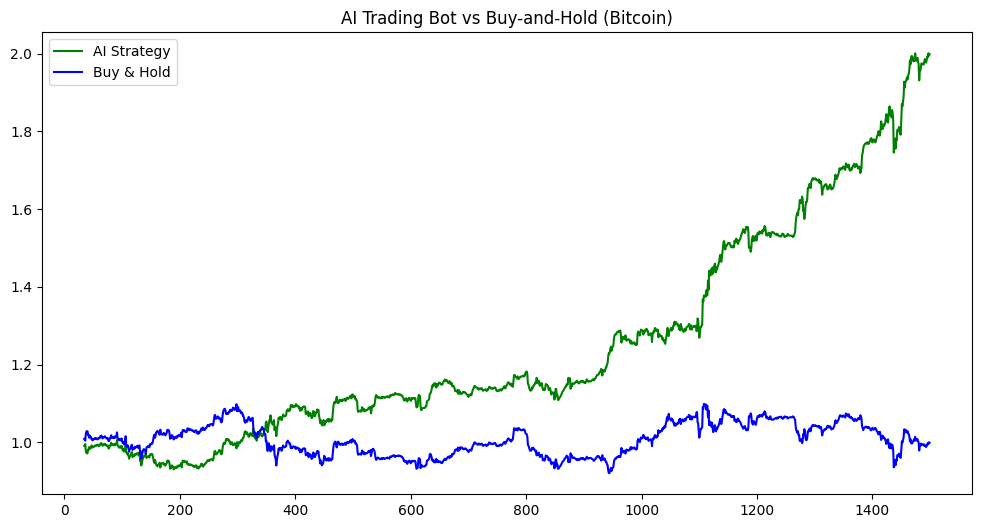

Your Balance:
{'info': {'makerCommission': 0, 'takerCommission': 0, 'buyerCommission': 0, 'sellerCommission': 0, 'commissionRates': {'maker': '0.00000000', 'taker': '0.00000000', 'buyer': '0.00000000', 'seller': '0.00000000'}, 'canTrade': True, 'canWithdraw': True, 'canDeposit': True, 'brokered': False, 'requireSelfTradePrevention': False, 'preventSor': False, 'updateTime': 1738760099294, 'accountType': 'SPOT', 'balances': [{'asset': 'ETH', 'free': '1.00000000', 'locked': '0.00000000'}, {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'}, {'asset': 'LTC', 'free': '4.00000000', 'locked': '0.00000000'}, {'asset': 'BNB', 'free': '1.00000000', 'locked': '0.00000000'}, {'asset': 'USDT', 'free': '10000.00000000', 'locked': '0.00000000'}, {'asset': 'TRX', 'free': '2203.00000000', 'locked': '0.00000000'}, {'asset': 'XRP', 'free': '195.00000000', 'locked': '0.00000000'}, {'asset': 'NEO', 'free': '44.00000000', 'locked': '0.00000000'}, {'asset': 'QTUM', 'free': '150.00000000', 'locked

In [37]:
import ccxt
import pandas as pd
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Fetch data
exchange = ccxt.kucoin()
ohlcv = exchange.fetch_ohlcv('BTC/USDT', '1h', limit=2880)  # Fetch 120 days of data
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Add technical indicators using pandas-ta
df['rsi'] = ta.rsi(df['close'], length=14)
df['ema'] = ta.ema(df['close'], length=20)
macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
df['macd'] = macd['MACD_12_26_9']
df['macd_signal'] = macd['MACDh_12_26_9']
df['macd_hist'] = macd['MACDs_12_26_9']

# Add additional features
df['volatility'] = (df['high'] - df['low']) / df['close']  # Volatility
df['momentum'] = df['close'].pct_change(periods=5) * 100  # Momentum over 5 periods
df['volume_ratio'] = df['volume'] / df['volume'].rolling(window=10).mean()  # Volume ratio

# Add lag features
for i in range(1, 4):
    df[f'lag_{i}'] = df['close'].shift(i)

# Drop rows with NaNs
df.dropna(inplace=True)

# Define target and features
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)  # Target: 1 if price increases, 0 otherwise
features = [
    'open', 'high', 'low', 'close', 'volume', 'rsi', 'ema', 'macd', 'macd_signal', 'macd_hist',
    'volatility', 'momentum', 'volume_ratio', 'lag_1', 'lag_2', 'lag_3'
]

# Split data
train = df[:-100]
test = df[-100:]

# Handle imbalanced data using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train[features], train['target'])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(test[features])

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(test['target'])

# Reshape data for LSTM (samples, timesteps, features)
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Use the last 10 time steps as input
X_train_lstm, y_train_lstm = create_dataset(X_train_scaled, y_train_encoded, time_steps)
X_test_lstm, y_test_lstm = create_dataset(X_test_scaled, y_test_encoded, time_steps)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

# Evaluate the model
y_pred_prob = model.predict(X_test_lstm)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test_lstm, y_pred)
print(f"LSTM Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(y_test_lstm, y_pred))

# Predict on the entire dataset
full_X_scaled = scaler.transform(df[features])
full_X_lstm, _ = create_dataset(full_X_scaled, np.zeros(len(full_X_scaled)), time_steps)

# Get predictions
predictions = (model.predict(full_X_lstm) > 0.5).astype(int).flatten()

# Create a temporary DataFrame to hold predictions with correct index alignment
predictions_df = pd.DataFrame(predictions, index=df.index[time_steps:], columns=['prediction'])

# Join the predictions back to the original DataFrame
df = df.join(predictions_df, how='left')

# Fill NaN values in 'prediction' column (introduced due to time_steps shift)
df['prediction'] = df['prediction'].ffill()  # Forward fill NaN
df['prediction'] = df['prediction'].fillna(0)  # If any NaNs remain fill with 0

# Create signals: Buy=1, Sell=-1, Hold=0
df['signal'] = 0
df.loc[df['prediction'] == 1, 'signal'] = 1   # Buy when AI predicts price up
df.loc[df['prediction'] == 0, 'signal'] = -1  # Sell when AI predicts price down

print("\nLatest Signals:")
print(df[['timestamp', 'close', 'signal']].tail(10))

# Calculate strategy returns
df['returns'] = df['close'].pct_change()  # Hourly price changes
df['strategy_returns'] = df['signal'].shift(1) * df['returns']  # Apply signals

# Plot performance
plt.figure(figsize=(12, 6))
plt.plot((1 + df['strategy_returns']).cumprod(), label='AI Strategy', color='green')
plt.plot((1 + df['returns']).cumprod(), label='Buy & Hold', color='blue')
plt.title("AI Trading Bot vs Buy-and-Hold (Bitcoin)")
plt.legend()
plt.show()

# Connect to Binance Testnet
exchange = ccxt.binance({
    'apiKey': 'sWcaTSTMc9HLOa25gwM5eiIGxVNGX6GYtIp0oTHIvw8fKc807Atjsd4jQTbgOXBH',
    'secret': 'ylX5bCAnRujVwL3eH1FE99Gh8Y67Udcr86i05CiQyV7kbyrYtL36ecEgjIlzRSet',
    'enableRateLimit': True,
    'options': {
        'defaultType': 'spot',
    },
    'urls': {
        'api': {
            'public': 'https://testnet.binance.vision/api/v3',
            'private': 'https://testnet.binance.vision/api/v3',
        }
    }
})
exchange.set_sandbox_mode(True)

# Fetch balance
Balance = exchange.fetch_balance()
print("Your Balance:")
print(Balance)
